In [ ]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D, concatenate, AveragePooling2D
from tensorflow.keras.layers import Conv2DTranspose, Dropout, Concatenate
from tensorflow.keras.layers import LeakyReLU, Activation, Flatten, Dense, Reshape, InputLayer, Input, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets.fashion_mnist import load_data
from tensorflow.keras.datasets import mnist
from tensorflow.keras import backend as K
import cv2
import os
import matplotlib
import keras
import pandas as pd
from google.colab.patches import cv2_imshow

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from google.colab.patches import cv2_imshow
import math
from math import log10, sqrt
from skimage.metrics import structural_similarity as ssim
from copy import deepcopy
import random

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#train data
try:
  del imageNoise
  del imageClear
  del imageNoise_valid
  del imageClear_valid
except Exception:
  pass
#image with reflects
imageClear = []
imageNoise = []
image_clear_path = '/content/drive/MyDrive/baza/database/clear/'
image_noise_path = '/content/drive/MyDrive/baza/database/reflects/'
for image in os.listdir(image_clear_path):
  imageClear.append(cv2.imread(os.path.join(image_clear_path, image)))
  imageNoise.append(cv2.imread(os.path.join(image_noise_path, image)))

imageClear = np.array(imageClear, dtype='object')
imageNoise = np.array(imageNoise, dtype='object')

imageClear = imageClear.astype('float32') / 255.
imageNoise = imageNoise.astype('float32') / 255.

#validation data
#image with reflects
image_clear_valid_path = '/content/drive/MyDrive/baza/test_base/valid/true/'
image_noise_valid_path = '/content/drive/MyDrive/baza/test_base/valid/reflects/'

imageClear_valid = []
imageNoise_valid = []
for image in os.listdir(image_clear_valid_path):
  imageClear_valid.append(cv2.imread(os.path.join(image_clear_valid_path, image)))
  imageNoise_valid.append(cv2.imread(os.path.join(image_noise_valid_path, image)))
imageNoise_valid = np.array(imageNoise_valid, dtype='object').astype('float32')
imageClear_valid = np.array(imageClear_valid, dtype='object').astype('float32')






imageNoise_valid = imageNoise_valid / 255.
imageClear_valid = imageClear_valid / 255.
#imageNoise_valid = np.array([prepare_image( imageClear_valid[idx] ) for idx in range(len(imageClear_valid))], dtype='object')
#dataset normalization

In [ ]:
#model called trixie - UNet++ type
class My_Model_Arch():
  def __init__(self):
    self.kernel_size = ( 3, 3)
  def __prepare_model(self):
    kernel_size = self.kernel_size
    input = Input((256,256,3))
    conv1 = Conv2D(32, kernel_size = kernel_size, activation = 'relu', padding = 'same')(input)
    conv1_2 = Conv2D(32, kernel_size = kernel_size, activation = 'relu', padding = 'same')(conv1)
    conv1_concat = concatenate([conv1, conv1_2], axis = -1)#32
    pool1 = MaxPooling2D(pool_size = (2,2))(conv1_concat)
    conv2 = Conv2D(64, kernel_size = kernel_size, activation = 'relu', padding = 'same')(pool1)
    conv2_1 = Conv2D(64, kernel_size = kernel_size, activation = 'relu', padding = 'same')(conv2)
    conv2_concat = concatenate([conv2_1, conv2], axis = -1)#64

    pool2 = MaxPooling2D(pool_size = (2,2))(conv2_concat)
    conv3 = Conv2D(128, kernel_size = kernel_size, activation = 'relu', padding = 'same')(pool2)
    conv3_1 = Conv2D(128, kernel_size = kernel_size, activation = 'relu', padding = 'same')(conv3)
    conv3_concat = concatenate([conv3, conv3_1], axis = -1)#128

    pool3 = MaxPooling2D(pool_size = (2,2))(conv3_concat)
    conv4 = Conv2D(256, kernel_size = kernel_size, activation = 'relu', padding = 'same')(pool3)
    conv4_1 = Conv2D(256, kernel_size = kernel_size, activation = 'relu', padding = 'same')(conv4)
    conv4_concat = concatenate([conv4, conv4_1], axis = -1)#256

    pool4 = MaxPooling2D(pool_size = (2,2))(conv4_concat)
    conv5 = Conv2D(512, kernel_size = kernel_size, activation = 'relu', padding = 'same')(pool4)
    conv5 = Conv2D(512, kernel_size = kernel_size, activation = 'relu', padding = 'same')(conv5)

    up1 = Conv2DTranspose(filters = 256, kernel_size=(2,2), strides=(2,2), padding = 'same', activation = 'relu')(conv5)
    up1 = concatenate([ conv4_concat, up1 ] , axis = 3)
    conv6 = Conv2D(256, kernel_size = kernel_size, activation = 'relu', padding = 'same')(up1)
    conv6 = Conv2D(256, kernel_size = kernel_size, activation = 'relu', padding = 'same')(conv6)
    up7 = Conv2DTranspose(filters = 128, kernel_size=(2,2), strides=(2,2), padding = 'same', activation = 'relu')(conv6)
    up7 = concatenate([conv3, up7], axis = 3)
    conv7 = Conv2D(128, kernel_size = kernel_size, activation = 'relu', padding = 'same')(up7)
    conv7_1 = Conv2D(128, kernel_size = kernel_size, activation = 'relu', padding = 'same')(conv7)
    concat_1_up = concatenate([conv7, conv7_1], axis = 3)#128 concat

    up8 = Conv2DTranspose(filters = 64, kernel_size=(2,2), strides=(2,2), padding = 'same', activation = 'relu')(concat_1_up)
    up8 = concatenate([conv2_concat, up8], axis = 3)
    conv8 = Conv2D(64, kernel_size = kernel_size, activation = 'relu', padding = 'same')(up8)
    conv8_1 = Conv2D(64, kernel_size = kernel_size, activation = 'relu', padding = 'same')(conv8)
    concat_2_up = concatenate([conv8, conv8_1], axis = 3)#64 concat

    up9 = Conv2DTranspose(filters = 32, kernel_size=(2,2), strides=(2,2), padding = 'same', activation = 'relu')(concat_2_up)
    up9 = concatenate([conv1_concat, up9], axis = 3)
    conv9 = Conv2D(filters = 32, kernel_size = kernel_size, activation = 'relu', padding = 'same')(up9)
    output = Conv2D(filters = 3, kernel_size = kernel_size, activation='sigmoid', padding='same')(conv9)
    model = Model(input ,    output)
    return model

  def SSIM(self, x_true, x_pred):
    return tf.image.ssim(x_true, x_pred, max_val=1.0, filter_size=11,
                          filter_sigma=1.5, k1=0.01, k2=0.03)
  def PSNR(self, original_image, reconstructed_image):
    return tf.image.psnr(original_image, reconstructed_image, max_val=1)

  def ssim_loss(self, y_true, y_pred):
    return 1.-tf.image.ssim(y_true, y_pred, max_val=1.0, filter_size=11,
                          filter_sigma=1.5, k1=0.01, k2=0.03)+1./self.PSNR(y_true, y_pred)

  def make_compiled_model(self):
    model = self.__prepare_model()
    model.compile(loss=self.ssim_loss, optimizer=Adam(learning_rate=0.001), metrics=[self.SSIM, self.PSNR])
    return model

model = My_Model_Arch().make_compiled_model()

In [ ]:
if imageClear.shape == imageNoise.shape:
  print(imageClear.shape, imageNoise.shape)
  train_history = model.fit(
    imageNoise,
    imageClear,
    epochs=65,
    shuffle=True,
    batch_size = 32,
    validation_data=(imageNoise_valid, imageClear_valid)
)

(1195, 256, 256, 3) (1195, 256, 256, 3)
Epoch 1/65
38/38 [==============================] - 102s 2s/step - loss: 0.4089 - SSIM: 0.6612 - PSNR: 14.9474 - val_loss: 0.2785 - val_SSIM: 0.7773 - val_PSNR: 18.4017
Epoch 2/65
38/38 [==============================] - 58s 2s/step - loss: 0.2226 - SSIM: 0.8265 - PSNR: 21.2107 - val_loss: 0.1718 - val_SSIM: 0.8682 - val_PSNR: 25.8401
Epoch 3/65
38/38 [==============================] - 58s 2s/step - loss: 0.1460 - SSIM: 0.8931 - PSNR: 26.1035 - val_loss: 0.1309 - val_SSIM: 0.9068 - val_PSNR: 26.7816
Epoch 4/65
38/38 [==============================] - 58s 2s/step - loss: 0.1145 - SSIM: 0.9218 - PSNR: 27.8730 - val_loss: 0.1091 - val_SSIM: 0.9257 - val_PSNR: 29.0888
Epoch 5/65
38/38 [==============================] - 58s 2s/step - loss: 0.0984 - SSIM: 0.9363 - PSNR: 29.2221 - val_loss: 0.0956 - val_SSIM: 0.9376 - val_PSNR: 30.4063
Epoch 6/65
38/38 [==============================] - 58s 2s/step - loss: 0.0902 - SSIM: 0.9434 - PSNR: 30.1133 - val_los

In [ ]:
tf.keras.models.save_model( model, 'drive/MyDrive/model/tests/test_unet_skip_connects.h5' )

In [ ]:
imageClear = []
image_clear_path = '/content/drive/MyDrive/baza/test_base/true_image_test/'
for image in os.listdir(image_clear_path):
  imageClear.append(cv2.imread(os.path.join(image_clear_path, image)))

imageClear = np.array(imageClear, dtype='object')

imageClear = imageClear.astype('float32') / 255.
prediction = model.predict(imageClear)

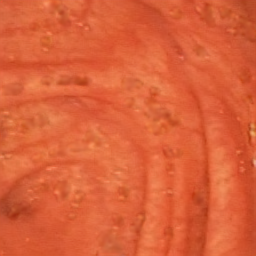

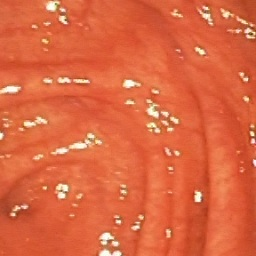

In [ ]:
idx = 9
cv2_imshow(prediction[idx]* 255.)
cv2_imshow(imageClear[idx]* 255.)